# Assignment 1
## Question `1` (K-Nearest Neighbour)

| | |
|-|-|
| Course | Statistical Methods in AI |
| Release Date | `19.01.2023` |
| Due Date | `29.01.2023` |

### Instructions:
1.   Assignment must be implemented using python notebook only (Colab , VsCode , Jupyter etc.)
2.   You are allowed to use libraries for data preprocessing (numpy, pandas, nltk etc) and for algorithms as well (sklearn etc). You are not however allowed to directly use classifier models.
3.   The performance of the model will hold weightage but you will also be graded largely for data preprocessing steps , explanations , feature selection for vectors etc.
4.   Strict plagiarism checking will be done. An F will be awarded for plagiarism.

### The Dataset
The dataset is to be downloaded from the following drive link ([Link](https://drive.google.com/file/d/1u55iIrTrn41n2lv8HBjtdKLhDcy_6s7O/view?usp=sharing)).
The dataset is a collection of *11099 tweets and has 31 columns*. The data will be in the form of a csv file which you can load in any format. The ground truth is available in the following drive link ([Link](https://drive.google.com/file/d/1--cozM5hXDwdbbDaWlB-8NqwSj0nh1Kg/view?usp=sharing)) which corresponds to whether a tweet was popular or not. Since the task involves selecting features yourself to vectorize a tweet , we suggest some data analysis of the columns you consider important.
<br><br>

### The Task
You have to build a classifier which can predict the popularity of the tweet, i.e , if the tweet was popular or not. You are required to use **KNN** algorithm to build the classifier and cannot use any inbuilt classifier. All columns are supposed to be analyzed , filtered and preprocessed to determine its importance as a feature in the vector for every tweet (Not every column will be useful).<br>
The Data contains the **raw text of the tweet**(in the text column) as well as other **meta data** like likes count , user followers count. Note that it might be useful to **create new columns** with useful information. For example, *number of hashtags* might be useful but is not directly present as a column.<br>
There are 3 main sub parts:
1. *Vectorize tweets using only meta data* - likes , user followers count , and other created data
2. *Vectorize tweets using only it's text*. This segment will require NLP techniques to clean the text and extract a vector using a BoW model. Here is a useful link for the same - [Tf-Idf](https://towardsdatascience.com/text-vectorization-term-frequency-inverse-document-frequency-tfidf-5a3f9604da6d). Since these vectors will be very large , we recommend reducing their dimensinality (~10 - 25). Hint: [Dimentionality Reduction](https://jonathan-hui.medium.com/machine-learning-singular-value-decomposition-svd-principal-component-analysis-pca-1d45e885e491). Please note that for this also you are allowed to use libraries.

3. *Combining the vectors from above two techinques to create one bigger vector*
<br>


Using KNN on these vectors build a classifier to predict the popularity of the tweet and report accuracies on each of the three methods as well as analysis. You can use sklearn's Nearest Neighbors and need not write KNN from scratch. (However you cannot use the classifier directly). You are expected to try the classifier for different number of neighbors and identify the optimal K value.

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import json
import math
import matplotlib.pyplot as plt

## Load and display the data

In [2]:
tweets = pd.read_json('tweets.json',lines=True)
#displaying necessary analysis
print(len(tweets))
print("Column names are: ", tweets.columns)
print("Displaying Information: ", tweets.info())

11099
Column names are:  Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'lang', 'possibly_sensitive', 'quoted_status_id',
       'quoted_status_id_str', 'extended_entities', 'quoted_status',
       'withheld_in_countries'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11099 entries, 0 to 11098
Data columns (total 31 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 11099 non-null  datetime64[ns, UTC]
 1   id                         11099 non-null  int64              


In [3]:
"""Necessary Functions for Preprocessing"""
def read_dictionary(df, column, keys):
    df = pd.concat([df.drop([column], axis=1), df[column].apply(pd.Series)], axis=1)
    return df
def list_to_string(df, column):
    df[column] = df[column].astype(str)
    return df
def drop_columns(df, columns):
    df.drop(columns, axis=1, inplace=True)
    return df
def choose_columns(df, columns):
    df = df[columns]
    return df
def display_unique_values(df, column):
    print("Unique values in ", column, " are: ", df[column].unique())

#converting the entities column to hashtags, symbols and urls to get more data
tweets = read_dictionary(tweets, 'entities', ['hashtags', 'symbols','urls'])
tweets.head()

,created_at,id,id_str,text,truncated,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,...,quoted_status_id,quoted_status_id_str,extended_entities,quoted_status,withheld_in_countries,hashtags,symbols,user_mentions,urls,media
0,2018-07-31 13:34:40+00:00,1024287229525598210,1024287229525598208,RT @KWWLStormTrack7: We are more than a month ...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'KWWLStormTrack7', 'name': 'K...",[],NaN
1,2018-07-31 13:34:40+00:00,1024287229512953856,1024287229512953856,@hail_ee23 Thanks love its just the feeling of...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.024128e+18,1.024128e+18,9.271857e+17,...,NaN,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'hail_ee23', 'name': 'Jordan ...",[],NaN
2,2018-07-31 13:34:40+00:00,1024287229504569344,1024287229504569344,RT @TransMediaWatch: Pink News has more on the...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'TransMediaWatch', 'name': 'T...",[],NaN
3,2018-07-31 13:34:40+00:00,1024287229496029190,1024287229496029184,RT @realDonaldTrump: One of the reasons we nee...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'realDonaldTrump', 'name': 'D...",[],NaN
4,2018-07-31 13:34:40+00:00,1024287229492031490,1024287229492031488,RT @First5App: This hearing of His Word doesn’...,False,"{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,[],[],"[{'screen_name': 'First5App', 'name': 'First 5...",[],NaN


In [4]:
#choosing all columns we are potentially interested in
tweets = choose_columns(tweets,['text','truncated','lang','retweet_count','favorite_count','hashtags','symbols','urls'])

In [5]:
def count_hashtags(df, column):
    df['num_hashtags'] = df[column].apply(len)
    return df
def count_urls(df, column):
    df['num_urls'] = df[column].apply(len)
    return df
def count_symbols(df, column):
    df['num_symbols'] = df[column].apply(len)
    return df

#count the number of hashtags in a tweet
tweets = count_hashtags(tweets, 'hashtags')
tweets = count_urls(tweets,'urls')
tweets = count_symbols(tweets,'symbols')
tweets = drop_columns(tweets, ['hashtags', 'urls', 'symbols'])
tweets['truncated'].replace({False:0, True:1}, inplace=True)
tweets['lang'].replace({'en':1}, inplace=True) 
tweets['lang'] = np.where(tweets['lang'] != 1, 0, tweets['lang'])
tweets.head()

,text,truncated,lang,retweet_count,favorite_count,num_hashtags,num_urls,num_symbols
0,RT @KWWLStormTrack7: We are more than a month ...,0,1,3,0,0,0,0
1,@hail_ee23 Thanks love its just the feeling of...,0,1,0,0,0,0,0
2,RT @TransMediaWatch: Pink News has more on the...,0,1,5,0,0,0,0
3,RT @realDonaldTrump: One of the reasons we nee...,0,1,11106,0,0,0,0
4,RT @First5App: This hearing of His Word doesn’...,0,1,6,0,0,0,0


In [6]:
ground_truth = pd.read_csv('ground_truth.csv', header=None, names=['class'])
ground_truth.head()

,class
0,0.0
1,0.0
2,1.0
3,0.0
4,1.0


## Exploratory Data Analysis
*This is an ungraded section but is recommended to get a good grasp on the dataset*

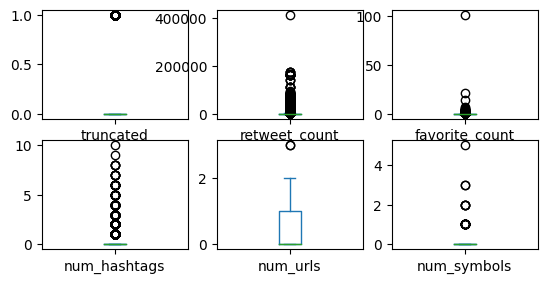

In [7]:
tweets.iloc[:,1:].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False)
plt.show()  

## Part-1
*Vectorize tweets using only meta data*

In [8]:
def get_features(matrix):
    
    """
    Funtion to return a matrix of dimensions (number of tweets, number of chosen features)
    Input parameters to this funcion are to be chosen as per requirement (Example: Loaded dataframe of the dataset) 
    """
    matrix = matrix[['retweet_count','truncated','lang','favorite_count','num_hashtags','num_urls','num_symbols']]
    return matrix.to_numpy()

featured_tweets = get_features(tweets)

Perform KNN using the vector obtained from get_features() function. Following are the steps to be followed:
1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values. 

In [9]:
#Function to normalize the vectors
def normalize(matrix):
    matrix_norm = (matrix - matrix.min(axis=0)) / (matrix.max(axis=0) - matrix.min(axis=0))
    return matrix_norm

md_tweets_norm = normalize(featured_tweets)

In [10]:
#splitting the dataset into training and testing
from sklearn.model_selection import train_test_split
md_X_train, md_X_test, md_y_train, md_y_test = train_test_split(md_tweets_norm, ground_truth['class'], test_size=0.3, random_state=13)
md_y_train = md_y_train.values.reshape(-1,1)
#y_test = y_test.values.reshape(-1,1)
print("Shape of X_train: ", md_X_train.shape)
print("Shape of X_test: ", md_X_test.shape)
print("Shape of y_train: ", md_y_train.shape)
print("Shape of y_test: ", md_y_test.shape)

Shape of X_train:  (7769, 7)
Shape of X_test:  (3330, 7)
Shape of y_train:  (7769, 1)
Shape of y_test:  (3330,)


In [11]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter
#Function to fit the model and use the maximum label of neighbouring points to classify
def md_fit_predict(X_train, X_test, y_train, y_test, neighbours):
    k_nearest = NearestNeighbors(n_neighbors=neighbours)
    k_nearest.fit(X_train)
    distances, indices = k_nearest.kneighbors(X_test) #indices of the nearest neighbours
    labels = y_train[indices]
    labels = labels.reshape(-1, neighbours).astype(int)
    y_pred = np.array([np.bincount(labels[i]).argmax() for i in range(len(labels))]) #most common label
    
    return y_pred

In [12]:
from sklearn.metrics import accuracy_score
ks=[]
accuracies=[]
#generating accuracy scores for different values of k
for i in range(1, 11):
    md_y_pred = md_fit_predict(md_X_train, md_X_test, md_y_train, md_y_test, i)
    accuracy = accuracy_score(md_y_test, md_y_pred)
    ks.append(i)
    accuracies.append(accuracy)
    print("Accuracy for k = ", i, " is: ", accuracy)

Accuracy for k =  1  is:  0.881981981981982
Accuracy for k =  2  is:  0.9162162162162162
Accuracy for k =  3  is:  0.9126126126126126
Accuracy for k =  4  is:  0.9165165165165166
Accuracy for k =  5  is:  0.9147147147147147
Accuracy for k =  6  is:  0.9174174174174174
Accuracy for k =  7  is:  0.9174174174174174
Accuracy for k =  8  is:  0.9174174174174174
Accuracy for k =  9  is:  0.9174174174174174
Accuracy for k =  10  is:  0.9174174174174174


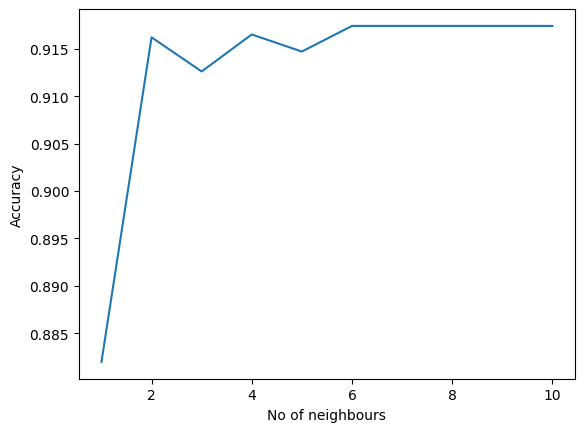

In [13]:
plt.plot(ks, accuracies)
plt.xlabel('No of neighbours')
plt.ylabel('Accuracy')
plt.show()


## Part-2
Vectorize tweets based on the text. More details and reference links can be checked on the Tasks list in the start of the notebook

In [14]:
import re
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
from sklearn.decomposition import PCA
pca = PCA(n_components=18)

In [15]:
def tweet_vectoriser(matrix):
    """
    Funtion to return a matrix of dimensions (number of tweets, number of features extracted per tweet)
    Following are the steps for be followed:
    1. Remove links, tags and hashtags from each tweet.
    2. Apply TF-IDF on the tweets to extract a vector. 
    3. Perform dimensionality reduction on the obtained vector. 
    Input parameters to this funcion are to be chosen as per requirement (Example: Array of tweets) 
    """
    # your code here
    matrix = matrix['text']
    matrix = matrix.str.lower()
    matrix = matrix.apply(lambda x: re.sub(r'https?:\/\/\S+', '', x))
    matrix = matrix.apply(lambda x: re.sub(r'@[^\s]+', '', x))
    matrix = matrix.apply(lambda x: re.sub(r'#[^\s]+', '', x))
    matrix = matrix.apply(lambda x: re.sub(r'<[^>]*>', '', x))
    matrix = matrix.apply(lambda x: re.sub(r'^rt', '', x))
    matrix = matrix.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    tf_idf_arr = tfidf.fit_transform(matrix)
    pca_arr = pca.fit_transform(tf_idf_arr.toarray())
    return pca_arr

tf_mat = tweet_vectoriser(tweets)
print(tf_mat.shape)
    

(11099, 18)


Perform KNN using the vector obtained from tweet_vectoriser() function. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

In [16]:
from sklearn.model_selection import train_test_split
ti_X_train, ti_X_test, ti_y_train, ti_y_test = train_test_split(tf_mat, ground_truth['class'], test_size=0.3, random_state=13)
ti_y_train = ti_y_train.values.reshape(-1,1)
#y_test = y_test.values.reshape(-1,1)
print("Shape of X_train: ", ti_X_train.shape)
print("Shape of X_test: ", ti_X_test.shape)
print("Shape of y_train: ", ti_y_train.shape)
print("Shape of y_test: ", ti_y_test.shape)

Shape of X_train:  (7769, 18)
Shape of X_test:  (3330, 18)
Shape of y_train:  (7769, 1)
Shape of y_test:  (3330,)


In [17]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter
#Function to fit and predict the class
def ti_fit_predict(X_train, X_test, y_train, y_test,neighbours):
    k_nearest = NearestNeighbors(n_neighbors=neighbours)
    k_nearest.fit(X_train)
    distances, indices = k_nearest.kneighbors(X_test)
    labels = y_train[indices]
    labels = labels.reshape(-1, neighbours).astype(int)
    y_pred = np.array([np.bincount(labels[i]).argmax() for i in range(len(labels))])
    return y_pred

In [18]:
from sklearn.metrics import accuracy_score
ti_ks=[]
ti_accuracies=[]
for i in range(1, 11):
    ti_y_pred = ti_fit_predict(ti_X_train, ti_X_test, ti_y_train, ti_y_test, i)
    accuracy = accuracy_score(ti_y_test, ti_y_pred)
    ti_ks.append(i)
    ti_accuracies.append(accuracy)
    print("Accuracy for k = ", i, " is: ", accuracy)

Accuracy for k =  1  is:  0.8558558558558559
Accuracy for k =  2  is:  0.912012012012012
Accuracy for k =  3  is:  0.9063063063063063
Accuracy for k =  4  is:  0.9177177177177177
Accuracy for k =  5  is:  0.9168168168168168
Accuracy for k =  6  is:  0.9177177177177177
Accuracy for k =  7  is:  0.9177177177177177
Accuracy for k =  8  is:  0.9174174174174174
Accuracy for k =  9  is:  0.9174174174174174
Accuracy for k =  10  is:  0.9174174174174174


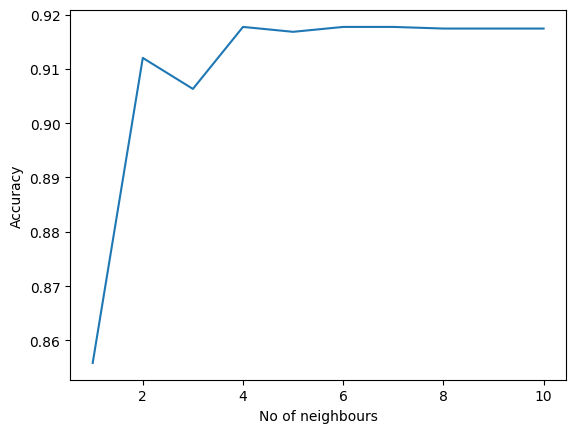

In [19]:
plt.plot(ti_ks, ti_accuracies)
plt.xlabel('No of neighbours')
plt.ylabel('Accuracy')
plt.show()

## Part-3
### Subpart-1

Combine both the vectors obtained from the tweet_vectoriser() and get_features()

In [20]:
#combining vectors
merged_vectors = np.concatenate((md_tweets_norm, tf_mat), axis=1)
print(merged_vectors.shape)

(11099, 25)


Perform KNN using the vector obtained in the previous step. Following are the steps to be followed:

1. Normalise the vectors
2. Split the data into training and test to estimate the performance.
3. Fit the Nearest Neughbiurs module to the training data and obtain the predicted class by getting the nearest neighbours on the test data.
4. Report the accuracy, chosen k-value and method used to obtain the predicted class. Hint: Plot accuracies for a range of k-values.

In [21]:
from sklearn.model_selection import train_test_split
merge_X_train, merge_X_test, merge_y_train, merge_y_test = train_test_split(merged_vectors, ground_truth['class'], test_size=0.3, random_state=13)
merge_y_train = merge_y_train.values.reshape(-1,1)
#y_test = y_test.values.reshape(-1,1)
print("Shape of X_train: ", merge_X_train.shape)
print("Shape of X_test: ", merge_X_test.shape)
print("Shape of y_train: ", merge_y_train.shape)
print("Shape of y_test: ", merge_y_test.shape)

Shape of X_train:  (7769, 25)
Shape of X_test:  (3330, 25)
Shape of y_train:  (7769, 1)
Shape of y_test:  (3330,)


In [22]:
from sklearn.neighbors import NearestNeighbors
from collections import Counter
#Function to fit and predict the class
def merge_fit_predict(X_train, X_test, y_train, y_test,neighbours):
    k_nearest = NearestNeighbors(n_neighbors=neighbours)
    k_nearest.fit(X_train)
    distances, indices = k_nearest.kneighbors(X_test)
    labels = y_train[indices]
    labels = labels.reshape(-1, neighbours).astype(int)
    y_pred = np.array([np.bincount(labels[i]).argmax() for i in range(len(labels))])
    return y_pred

In [23]:
from sklearn.metrics import accuracy_score
merge_ks=[]
merge_accuracies=[]
for i in range(1, 11):
    merge_y_pred = merge_fit_predict(merge_X_train, merge_X_test, merge_y_train, merge_y_test, i)
    accuracy = accuracy_score(merge_y_test, merge_y_pred)
    merge_ks.append(i)
    merge_accuracies.append(accuracy)
    print("Accuracy for k = ", i, " is: ", accuracy)

Accuracy for k =  1  is:  0.8477477477477477
Accuracy for k =  2  is:  0.9108108108108108
Accuracy for k =  3  is:  0.9
Accuracy for k =  4  is:  0.9171171171171171
Accuracy for k =  5  is:  0.9144144144144144
Accuracy for k =  6  is:  0.9168168168168168
Accuracy for k =  7  is:  0.9165165165165166
Accuracy for k =  8  is:  0.9174174174174174
Accuracy for k =  9  is:  0.9174174174174174
Accuracy for k =  10  is:  0.9174174174174174


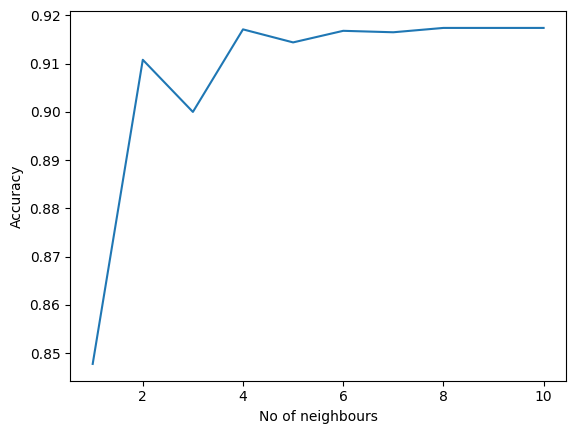

In [24]:
plt.plot(merge_ks, merge_accuracies)
plt.xlabel('No of neighbours')
plt.ylabel('Accuracy')
plt.show()

### Subpart-2

Explain the differences between the accuracies obtained in each part above based on the features used.

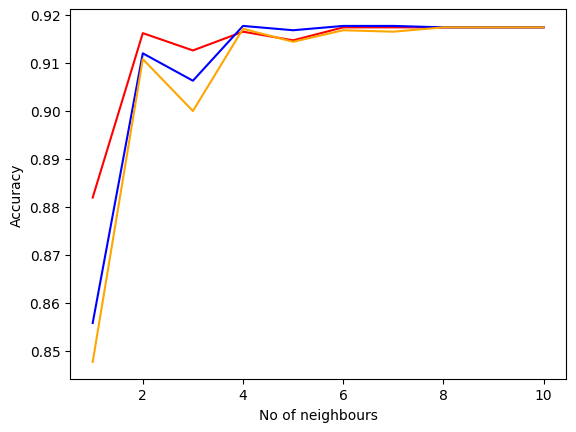

In [25]:
plt.plot(ks, accuracies,color='red')
plt.plot(ti_ks, ti_accuracies,color='blue')
plt.plot(merge_ks, merge_accuracies,color='orange')
plt.xlabel('No of neighbours')
plt.ylabel('Accuracy')
plt.show()

We note that for $k=1$, $k=2$ and $k=3$, vectoizing and using the metadata provides greater accuracy than the other 2 approaches. The vectorization based on text (BOW:Tf-IDF) produces superior results, however, for $k=4$ and $k=5$. The accuracy differences between the three approaches are minimal above $k=6$.  \
For `Part 1`: Highest accuracy: 0.9174174174174174 achieved at $k=6$. After which it remains constant. \
For `Part 2`: Highest accuracy: 0.9174174174174174 achieved at $k=6$. After which the accuracy starts decreasing.\
For `Part 3`: Highest accuracy: 0.9174174174174174 achieved at $k=6$. After which it decreases for $k=7$ but then becomes constant again for other values of $k$.